# BERT для entity-based sentiment analysis

In [1]:
!pip install transformers

     |████████████████████████████████| 573kB 3.4MB/s 
     |████████████████████████████████| 1.0MB 57.2MB/s 
     |████████████████████████████████| 3.7MB 49.8MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=94e81f12427ad2729998827f3b1e2fa879f471483b5e9cfdfa8c4240e40feed1
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
sns.set(font_scale=1.4)

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from transformers import AutoModel, AutoTokenizer,\
                         AdamW, get_linear_schedule_with_warmup

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загрузим датасет

In [2]:
restaurants_test = pd.read_csv(
    '/content/drive/My Drive/NLP/dialog-sent/data/processed/restaurants_test.csv'
)
restaurants_train = pd.read_csv(
    '/content/drive/My Drive/NLP/dialog-sent/data/processed/restaurants_train.csv'
)
restaurants_train, restaurants_val = train_test_split(
    restaurants_train, test_size=0.25
)

len(restaurants_train), len(restaurants_val), len(restaurants_test)

(2637, 879, 973)

Попробуем обучить BERT для определения тональности.

In [0]:
# Store the model we want to use
MODEL_NAME = "bert-base-cased"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(
    MODEL_NAME
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, 
    do_lower_case=True
)

In [0]:
class Dataset():

    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        text = self.data.iloc[index, 0]
        aspect = self.data.iloc[index, 1]
        if (aspect == 'anecdotes/miscellaneous'):
            aspect = 'anecdotes miscellaneous'
        sentiment = self.data.iloc[index, 2]
        return [text, aspect], sentiment - 1

    def __len__(self):
        return len(self.data)

train_dataset = Dataset(restaurants_train)
val_datset = Dataset(restaurants_val)
test_dataset = Dataset(restaurants_test)

Создадим классификатор, который навесим на BERT.

In [0]:
class Classifier(nn.Module):

    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.linear_1 = nn.Linear(768, 3)
        self.softmax = nn.Softmax()

    def forward(self, x, attention_mask=None):
        _, x = self.bert(
            x, attention_mask=attention_mask
        )
        x = self.linear_1(x)
        x = self.softmax(x)
        return x

Зададим основные гиперпараметры:

In [0]:
model_classifier = Classifier(model).cuda()

n_epoch = 6
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5, 
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)
batch_size = 32

train_loss = []
val_loss = []

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_datset, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()

train_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = len(train_dataloader) * n_epoch
)

Начнем тренировочный цикл:

In [24]:
for epoch in tqdm(range(n_epoch)):
    model_classifier.train()
    current_train_loss = 0
    for x, y in tqdm(train_dataloader, leave=False):

        aspected_text = list(zip(*x))
        tokens = tokenizer.batch_encode_plus(
            aspected_text,
            pad_to_max_length=True,
            return_tensors='pt'
        )
        
        logits = model_classifier(
            tokens['input_ids'].cuda(),
            attention_mask=tokens['attention_mask'].cuda()            
        )
        loss = criterion(logits, y.cuda())
        current_train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        # избавимся от взрывающихся градиентов
        nn.utils.clip_grad_norm_(
            model_classifier.parameters(), 
            1.0
        )

        optimizer.step()
        train_scheduler.step()
        

    train_loss.append(current_train_loss / len(train_dataloader))

    model_classifier.eval()
    current_val_loss = 0
    for x, y in val_dataloader:

        aspected_text = list(zip(*x))
        tokens = tokenizer.batch_encode_plus(
            aspected_text,
            pad_to_max_length=True,
            return_tensors='pt'
        )

        logits = model_classifier(
            tokens['input_ids'].cuda(),
            attention_mask=tokens['attention_mask'].cuda()    
        )
        loss = criterion(logits, y.cuda())
        current_val_loss += loss.item()
        
    val_loss.append(current_val_loss / len(val_dataloader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


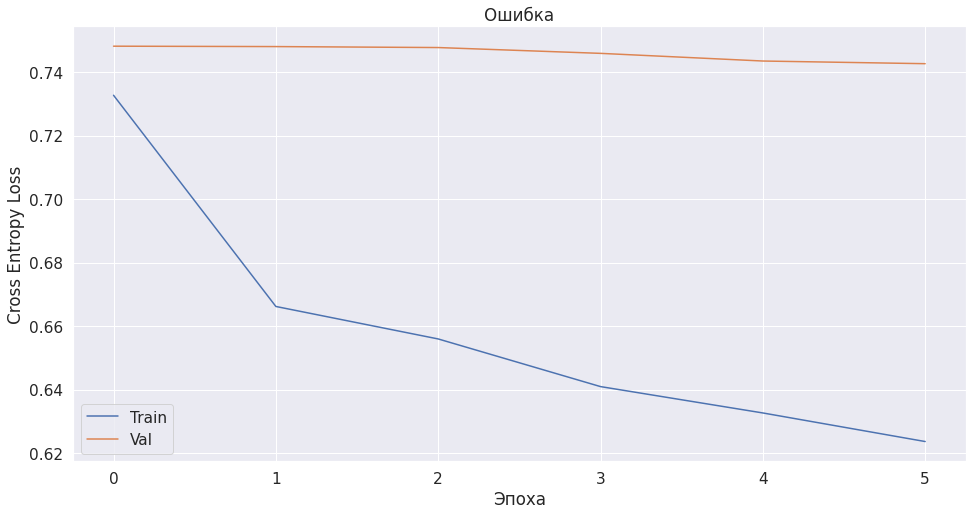

In [25]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Ошибка')
plt.xlabel('Эпоха')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.show()

Посчитаем среднее accuracy в батче:

In [0]:
torch.save(
    model_classifier.state_dict(), 
    '/content/drive/My Drive/NLP/dialog-sent/models/bert-base/classifier'
)

In [12]:
model_classifier.load_state_dict(
    torch.load(
        '/content/drive/My Drive/NLP/dialog-sent/models/bert-base/classifier'
    )
)

<All keys matched successfully>

Посмотрим на точность:

In [14]:
test_dataloader = DataLoader(
    test_dataset, batch_size=50
)

current_test_loss_acc = 0
current_test_loss_f1 = 0
current_test_loss_f1_macro = 0

for x, y in test_dataloader:

    aspected_text = list(zip(*x))
    tokens = tokenizer.batch_encode_plus(
        aspected_text,
        pad_to_max_length=True,
        return_tensors='pt'
    )

    logits = model_classifier(
        tokens['input_ids'].cuda(),
        attention_mask=tokens['attention_mask'].cuda()    
    ).argmax(dim=1)
    preds = logits.cpu().detach().numpy()
    current_test_loss_acc += accuracy_score(y.numpy(), preds)
    current_test_loss_f1 += f1_score(y.numpy(), preds, average='weighted')
    current_test_loss_f1_macro += f1_score(y.numpy(), preds, average='macro')

print('Accuracy: ', current_test_loss_acc / len(test_dataloader))
print('F1_score_weighted: ', current_test_loss_f1 / len(test_dataloader))
print('F1_macro: ', current_test_loss_f1_macro / len(test_dataloader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Accuracy:  0.865130434782609
F1_score_weighted:  0.862488965084508
F1_macro:  0.7581787321097733
